In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

In [2]:
fruits = pd.read_csv("fruits.csv", index_col=0)

### 1. Descripción del conjunto de datos

In [3]:
fruits.shape

(180, 5)

In [4]:
fruits.head()

,weight,length,width,regularity,cleft
0,1.205,4.603915,2.847,5.691634,Small
1,1.726,5.978000,3.594,4.539000,Large
2,1.126,4.516534,2.710,5.965993,Average
3,1.755,5.791000,3.690,5.366000,Large
4,1.238,4.666888,2.989,6.153947,Small


### 2. Preprocesado

2.1 Pasamos la columna categórica a numérica.

In [5]:
df = fruits.copy()

In [6]:
df['cleft'].value_counts()

Small         36
Large         36
Average       36
Very large    36
Very small    36
Name: cleft, dtype: int64

In [7]:
categories = ["Very small", "Small", "Average", "Large", "Very large"]
encoder = OrdinalEncoder(categories=[categories])
df['cleft'] = encoder.fit_transform(fruits[['cleft']])
df

,weight,length,width,regularity,cleft
0,1.205,4.603915,2.847,5.691634,1.0
1,1.726,5.978000,3.594,4.539000,3.0
2,1.126,4.516534,2.710,5.965993,2.0
3,1.755,5.791000,3.690,5.366000,3.0
4,1.238,4.666888,2.989,6.153947,1.0
...,...,...,...,...,...
175,1.345,NaN,3.065,3.531000,0.0
176,1.237,4.508595,2.960,4.655452,1.0
177,1.437,5.569000,3.153,1.464000,2.0
178,1.273,5.412000,2.882,3.533000,0.0


2.2 Vamos a usar scatterplots para ver cómo se distribuyen los puntos.

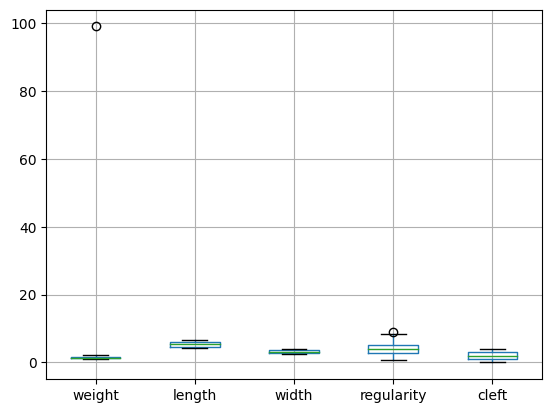

In [8]:
df.boxplot()
plt.show()

El dato atípico no nos permite ver la distribución de los puntos.

In [9]:
df[(df['weight'] == max(df['weight']))]

,weight,length,width,regularity,cleft
61,99.0,6.173,3.651,2.443,4.0


In [10]:
df = df[~(df['weight'] == max(df['weight']))]

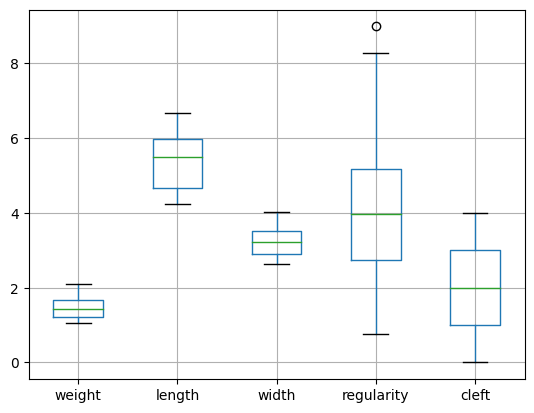

In [11]:
df.boxplot()
plt.show()

2.3 Ahora escalamos los datos usando StandardScaler()

In [12]:
df_scaled = df.copy()

In [13]:
df_scaled[df.columns] = StandardScaler().fit_transform(df[df.columns])
df_scaled

,weight,length,width,regularity,cleft
0,-0.905287,-1.114427,-1.049340,1.041740,-0.701189
1,0.927937,0.865562,0.933311,0.332433,0.717036
2,-1.183262,-1.240339,-1.412959,1.210575,0.007923
3,1.029978,0.596105,1.188110,0.841351,0.717036
4,-0.789171,-1.023686,-0.672451,1.326238,-0.701189
...,...,...,...,...,...
175,-0.412674,NaN,-0.470735,-0.287870,-1.410302
176,-0.792690,-1.251779,-0.749421,0.404095,-0.701189
177,-0.088957,0.276213,-0.237170,-1.559859,0.007923
178,-0.666018,0.049984,-0.956445,-0.286639,-1.410302


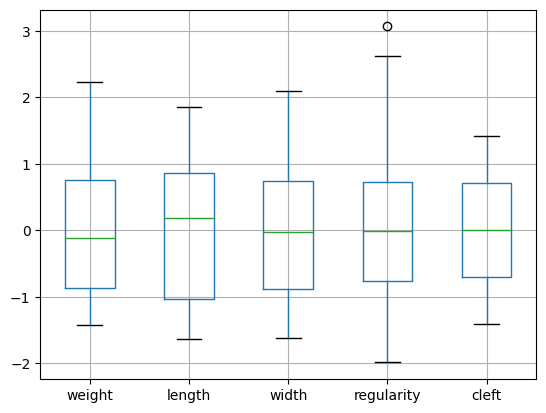

In [14]:
df_scaled.boxplot()
plt.show()

In [15]:
df_scaled.describe().loc[['mean', 'std'], :]

,weight,length,width,regularity,cleft
mean,-3.935641e-16,1.375244e-16,-1.562536e-15,-1.944533e-16,3.969512e-17
std,1.003008e+00,1.003241e+00,1.003101e+00,1.002972e+00,1.002805e+00


2.4 Ahora vamos a usar el KNNImputer sobre las variables continuas para rellenar los datos nulos.

In [16]:
df_scaled.isna().sum()

weight        12
length        24
width         17
regularity    10
cleft          0
dtype: int64

Veamos cómo se distribuyen los datos nulos.

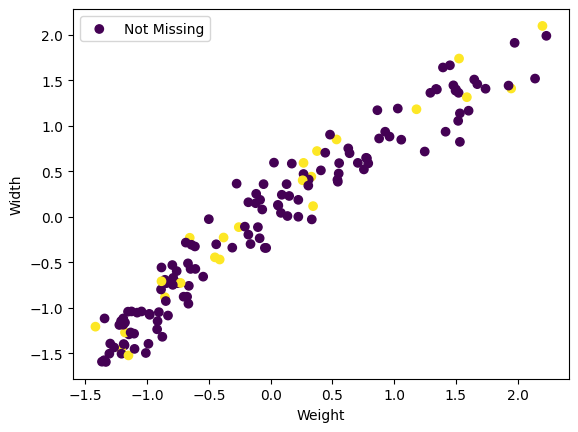

In [17]:
plt.scatter(df_scaled['weight'], df_scaled['width'], c=df_scaled['length'].isna())
plt.xlabel('Weight')
plt.ylabel('Width')
plt.legend(labels=['Not Missing', 'Missing'])
plt.show()

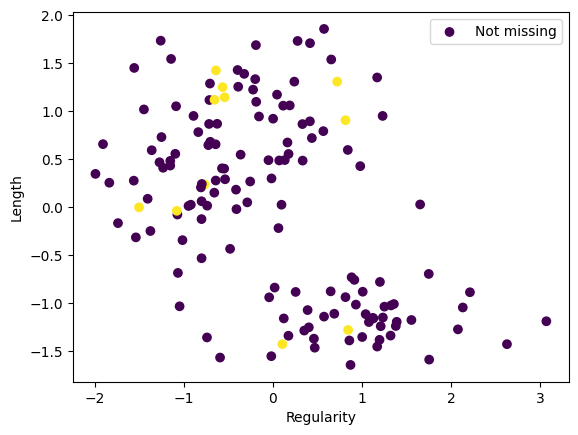

In [18]:
plt.scatter(df_scaled['regularity'], df_scaled['length'], c=df_scaled['weight'].isna())
plt.xlabel('Regularity')
plt.ylabel('Length')
plt.legend(labels=['Not missing', 'Missing'])
plt.show()

Los datos nulos se distribuyen CAR (Completely At Random) como podemos ver en las imágenes. Además, la relación entre las variables es directa, excepto con regularity.

In [19]:
df_imputted = df_scaled.copy()

In [20]:
imputer = KNNImputer(n_neighbors=3, weights="uniform")
df_imputted[df_scaled.columns] = imputer.fit_transform(df_scaled[df_scaled.columns])

In [21]:
df_imputted.isna().sum()

weight        0
length        0
width         0
regularity    0
cleft         0
dtype: int64

### 3. Métodos de clustering

3.1 Clustering jerárquico: Vamos a realizar clustering jerárquico usando la clase AgglomerativeClustering con diferentes parámetros.

In [22]:
from sklearn.cluster import AgglomerativeClustering

In [23]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Vamos a utilizar la anterior función para visualizar los dendrogramas. 
Veamos cómo funciona para los distintos 'linkage':

3.1.1 SINGLE LINKAGE

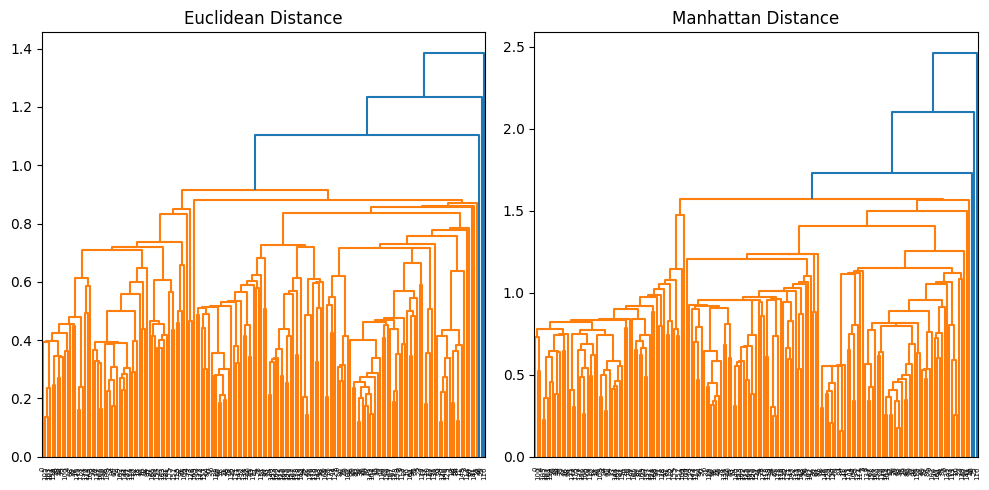

In [24]:
cl_single_euclidean = AgglomerativeClustering(distance_threshold=2.25, linkage="single", n_clusters=None, metric='euclidean').fit(df_imputted)
cl_single_manhattan = AgglomerativeClustering(distance_threshold=1.3, linkage="single", n_clusters=None, metric='manhattan').fit(df_imputted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Euclidean Distance")
plot_dendrogram(cl_single_euclidean, ax=ax1)

ax2.set_title("Manhattan Distance")
plot_dendrogram(cl_single_manhattan, ax=ax2)

plt.tight_layout()
plt.show()

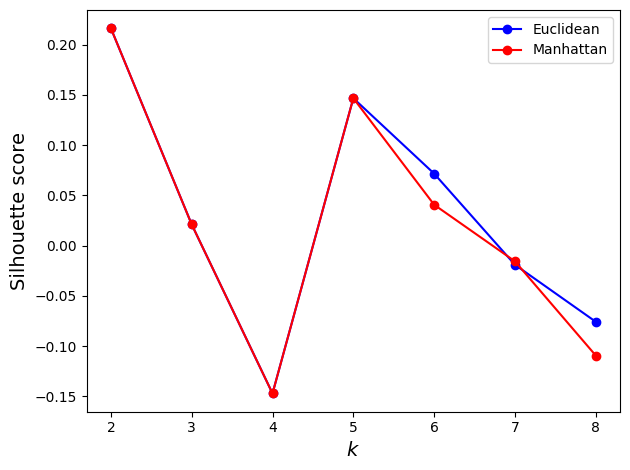

In [25]:
from sklearn.metrics import silhouette_score

models_single_euclidean = [AgglomerativeClustering(n_clusters=k, linkage='single', metric='euclidean').fit(df_imputted) for k in range(1, 9)]
silhouette_single_euclidean = [silhouette_score(df_imputted, model.labels_) for model in models_single_euclidean[1:]]

models_single_manhattan = [AgglomerativeClustering(n_clusters=k, linkage='single', metric='manhattan').fit(df_imputted) for k in range(1, 9)]
silhouette_single_manhattan = [silhouette_score(df_imputted, model.labels_) for model in models_single_manhattan[1:]]

plt.figure()
plt.plot(range(1, 9)[1:], silhouette_single_euclidean, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(range(1, 9)[1:], silhouette_single_manhattan, "ro-")
plt.legend(["Euclidean", "Manhattan"])
plt.tight_layout()
plt.show()

3.1.2 COMPLETE LINKAGE

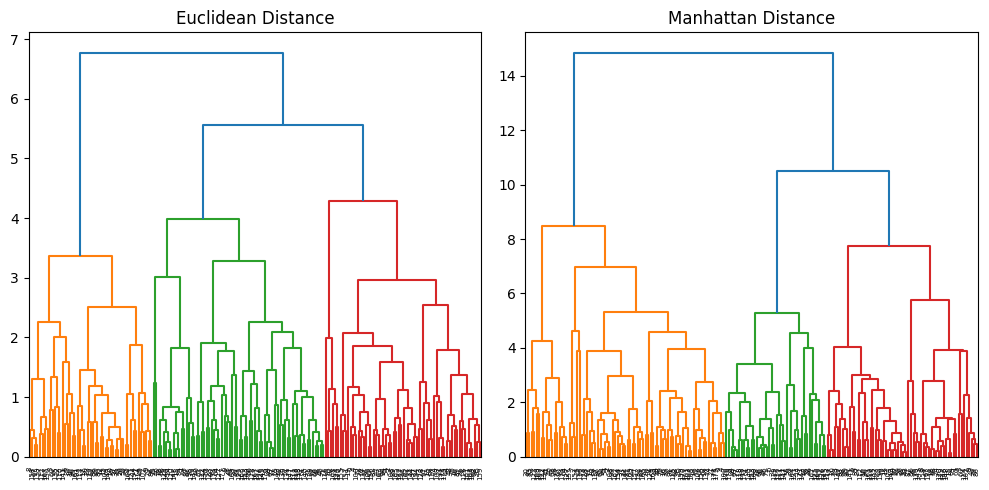

In [26]:
cl_complete_euclidean = AgglomerativeClustering(distance_threshold=5, linkage="complete", metric='euclidean', n_clusters=None).fit(df_imputted)
cl_complete_manhattan = AgglomerativeClustering(distance_threshold=12, linkage="complete", metric='manhattan', n_clusters=None).fit(df_imputted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Euclidean Distance")
plot_dendrogram(cl_complete_euclidean, ax=ax1)

ax2.set_title("Manhattan Distance")
plot_dendrogram(cl_complete_manhattan, ax=ax2)

plt.tight_layout()
plt.show()

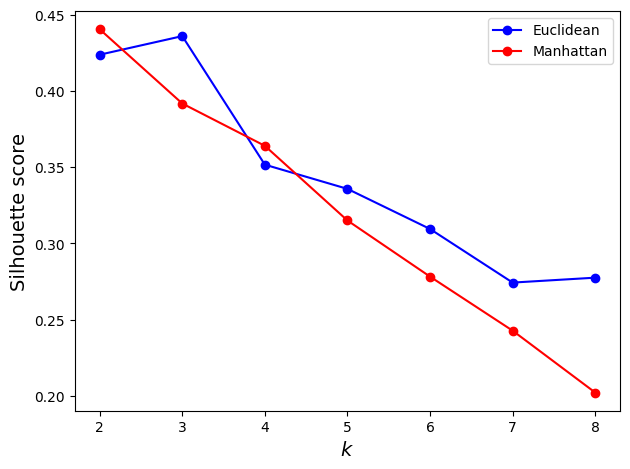

In [27]:
models_complete_euclidean = [AgglomerativeClustering(n_clusters=k, linkage='complete', metric='euclidean').fit(df_imputted) for k in range(1, 9)]
silhouette_complete_euclidean = [silhouette_score(df_imputted, model.labels_) for model in models_complete_euclidean[1:]]

models_complete_manhattan = [AgglomerativeClustering(n_clusters=k, linkage='complete', metric='manhattan').fit(df_imputted) for k in range(1, 9)]
silhouette_complete_manhattan = [silhouette_score(df_imputted, model.labels_) for model in models_complete_manhattan[1:]]

plt.figure()
plt.plot(range(1, 9)[1:], silhouette_complete_euclidean, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(range(1, 9)[1:], silhouette_complete_manhattan, "ro-")
plt.legend(["Euclidean", "Manhattan"])
plt.tight_layout()
plt.show()

3.1.3 AVERAGE LINKAGE

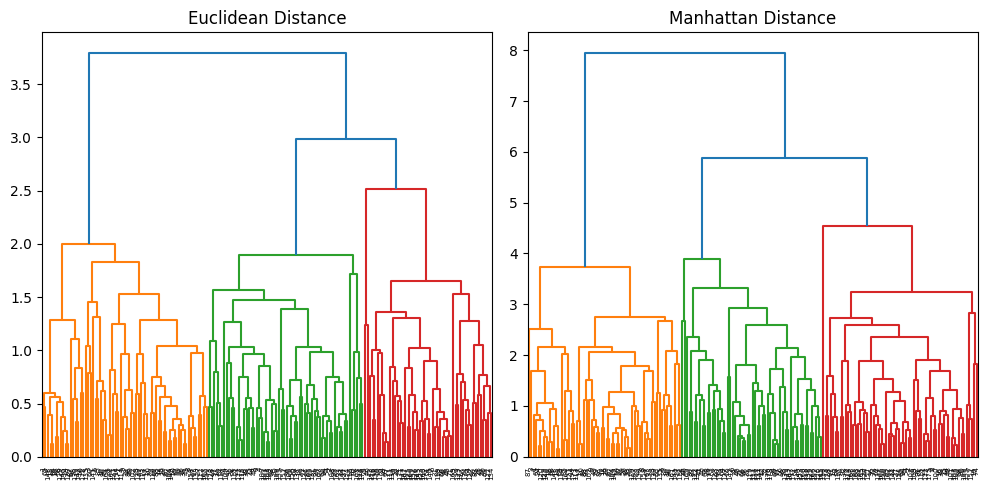

In [28]:
cl_avg_euclidean = AgglomerativeClustering(distance_threshold=2.8, linkage="average", metric='euclidean', n_clusters=None).fit(df_imputted)
cl_avg_manhattan = AgglomerativeClustering(distance_threshold=5, linkage="average", metric='manhattan', n_clusters=None).fit(df_imputted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Euclidean Distance")
plot_dendrogram(cl_avg_euclidean, ax=ax1)

ax2.set_title("Manhattan Distance")
plot_dendrogram(cl_avg_manhattan, ax=ax2)

plt.tight_layout()
plt.show()

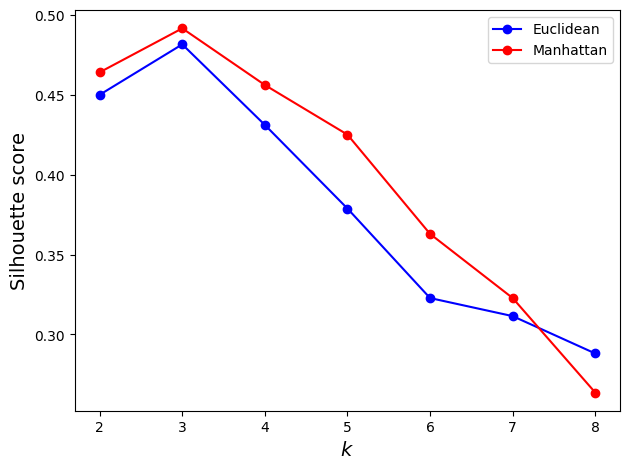

In [29]:
models_avg_euclidean = [AgglomerativeClustering(n_clusters=k, linkage='average', metric='euclidean').fit(df_imputted) for k in range(1, 9)]
silhouette_avg_euclidean = [silhouette_score(df_imputted, model.labels_) for model in models_avg_euclidean[1:]]

models_avg_manhattan = [AgglomerativeClustering(n_clusters=k, linkage='average', metric='manhattan').fit(df_imputted) for k in range(1, 9)]
silhouette_avg_manhattan = [silhouette_score(df_imputted, model.labels_) for model in models_avg_manhattan[1:]]

plt.figure()
plt.plot(range(1, 9)[1:], silhouette_avg_euclidean, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(range(1, 9)[1:], silhouette_avg_manhattan, "ro-")
plt.legend(["Euclidean", "Manhattan"])
plt.tight_layout()
plt.show()

3.1.4 WARD LINKAGE (sólo permite distancia euclídea)

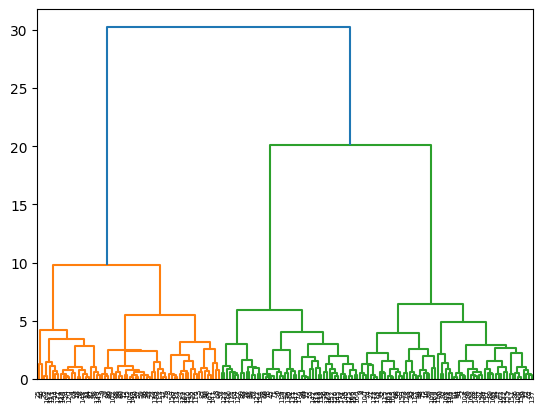

In [30]:
cl_ward = AgglomerativeClustering(distance_threshold=15, linkage="ward", n_clusters=None).fit(df_imputted)
plot_dendrogram(cl_ward)
plt.show()

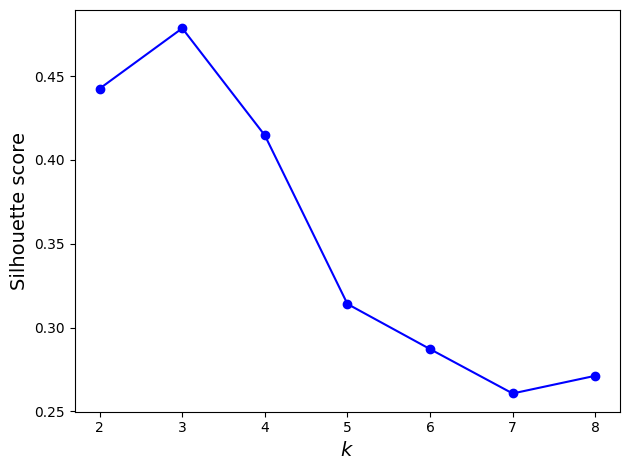

In [31]:
models_ward = [AgglomerativeClustering(n_clusters=k, linkage='ward').fit(df_imputted) for k in range(1, 9)]

silhouette_ward = [silhouette_score(df_imputted, model.labels_) for model in models_ward[1:]]

plt.figure()
plt.plot(range(1, 9)[1:], silhouette_ward, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.tight_layout()
plt.show()

Una vez obtenidos los diferentes resultados, vamos a visualizar los scatterplots de todas las variables 2 a 2 con los mejores clusters obtenidos.

En primer lugar, utilizando el linkage complete y la distancia manhattan (2 clusters):

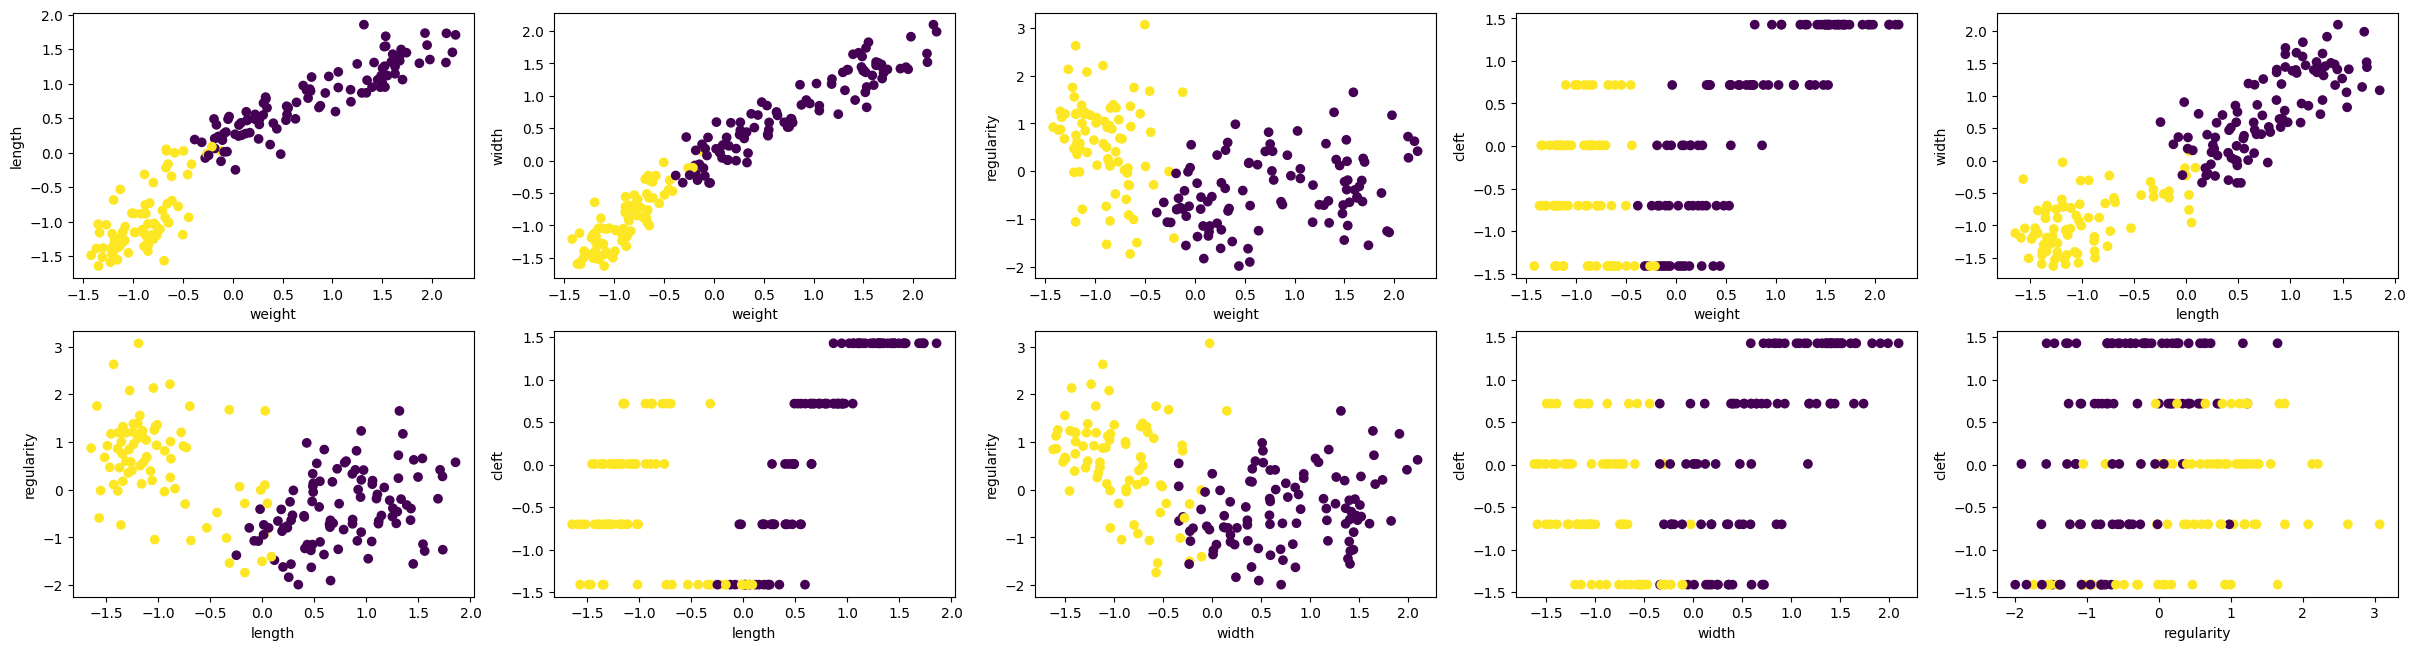

In [32]:
import itertools as it

columns = df_imputted.columns
fig = plt.figure(figsize=(30, 20))
for i, (x,y) in enumerate(it.combinations(columns, 2)):
    ax = fig.add_subplot(5, 5, i+1)
    ax.scatter(df_imputted[x], df_imputted[y], c=cl_complete_manhattan.labels_)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
plt.show()

En segundo lugar, utilizando linkage ward (3 clusters).

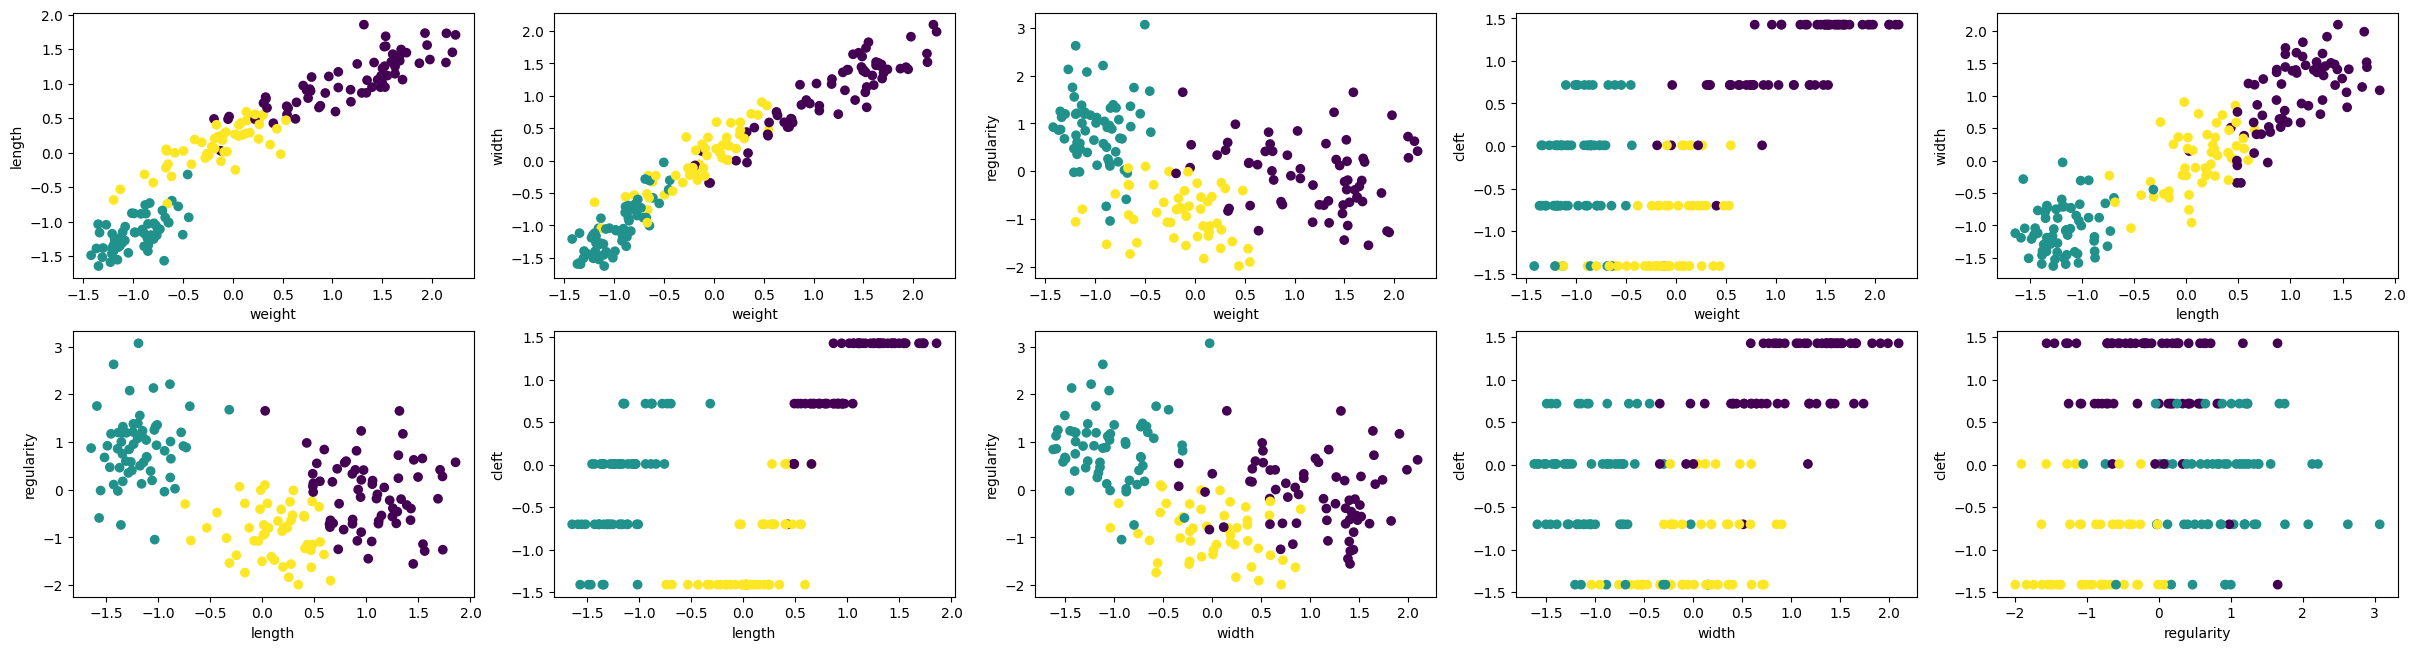

In [33]:
columns = df_imputted.columns
fig = plt.figure(figsize=(30, 20))
for i, (x,y) in enumerate(it.combinations(columns, 2)):
    ax = fig.add_subplot(5, 5, i+1)
    ax.scatter(df_imputted[x], df_imputted[y], c=cl_ward.labels_)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
plt.show()

Observamos que el resultado con k=2 está juntando dos clusters (el amarillo y el morado) en uno solo, con la posibilidad de estar perdiendo información.

3.2 PARTITIONAL CLUSTERING

In [34]:
from sklearn.cluster import KMeans

Vamos a evaluar los resultados que obtenemos al aplicar K-Means utilizando el coeficiente de silhouette y el gráfico de la 'inertia'.

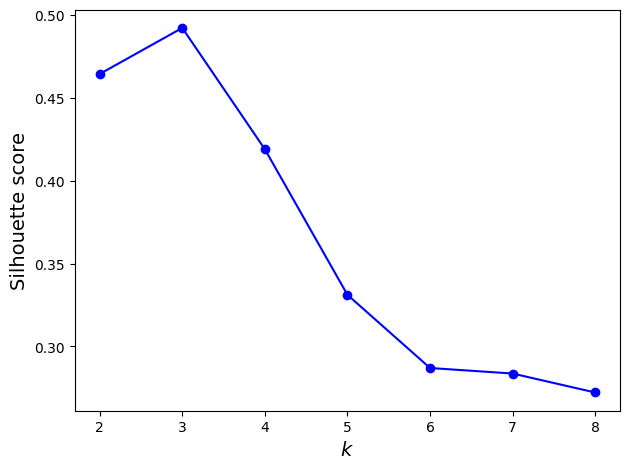

In [35]:
models_kmeans = [KMeans(n_clusters=k, n_init=10).fit(df_imputted) for k in range(1, 9)]

silhouette_kmeans = [silhouette_score(df_imputted, model.labels_) for model in models_kmeans[1:]]

plt.figure()
plt.plot(range(1, 9)[1:], silhouette_kmeans, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.tight_layout()
plt.show()

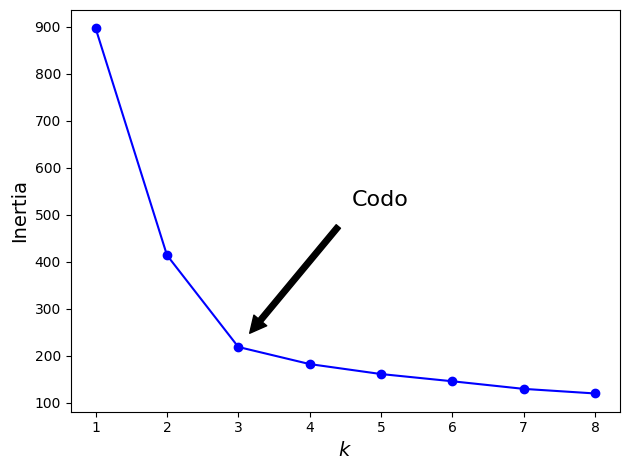

In [36]:
inertias = [model.inertia_ for model in models_kmeans]

plt.figure()
plt.plot(range(1, 9), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate(
    "Codo",
    xy=(3, inertias[2]),
    xytext=(0.55, 0.55),
    textcoords="figure fraction",
    fontsize=16,
    arrowprops=dict(facecolor="black", shrink=0.1),
)
plt.tight_layout()
plt.show()

En ambos gráficos parece que la solución óptima es k=3 clusters. Visualicemos los scatterplots de nuevo:

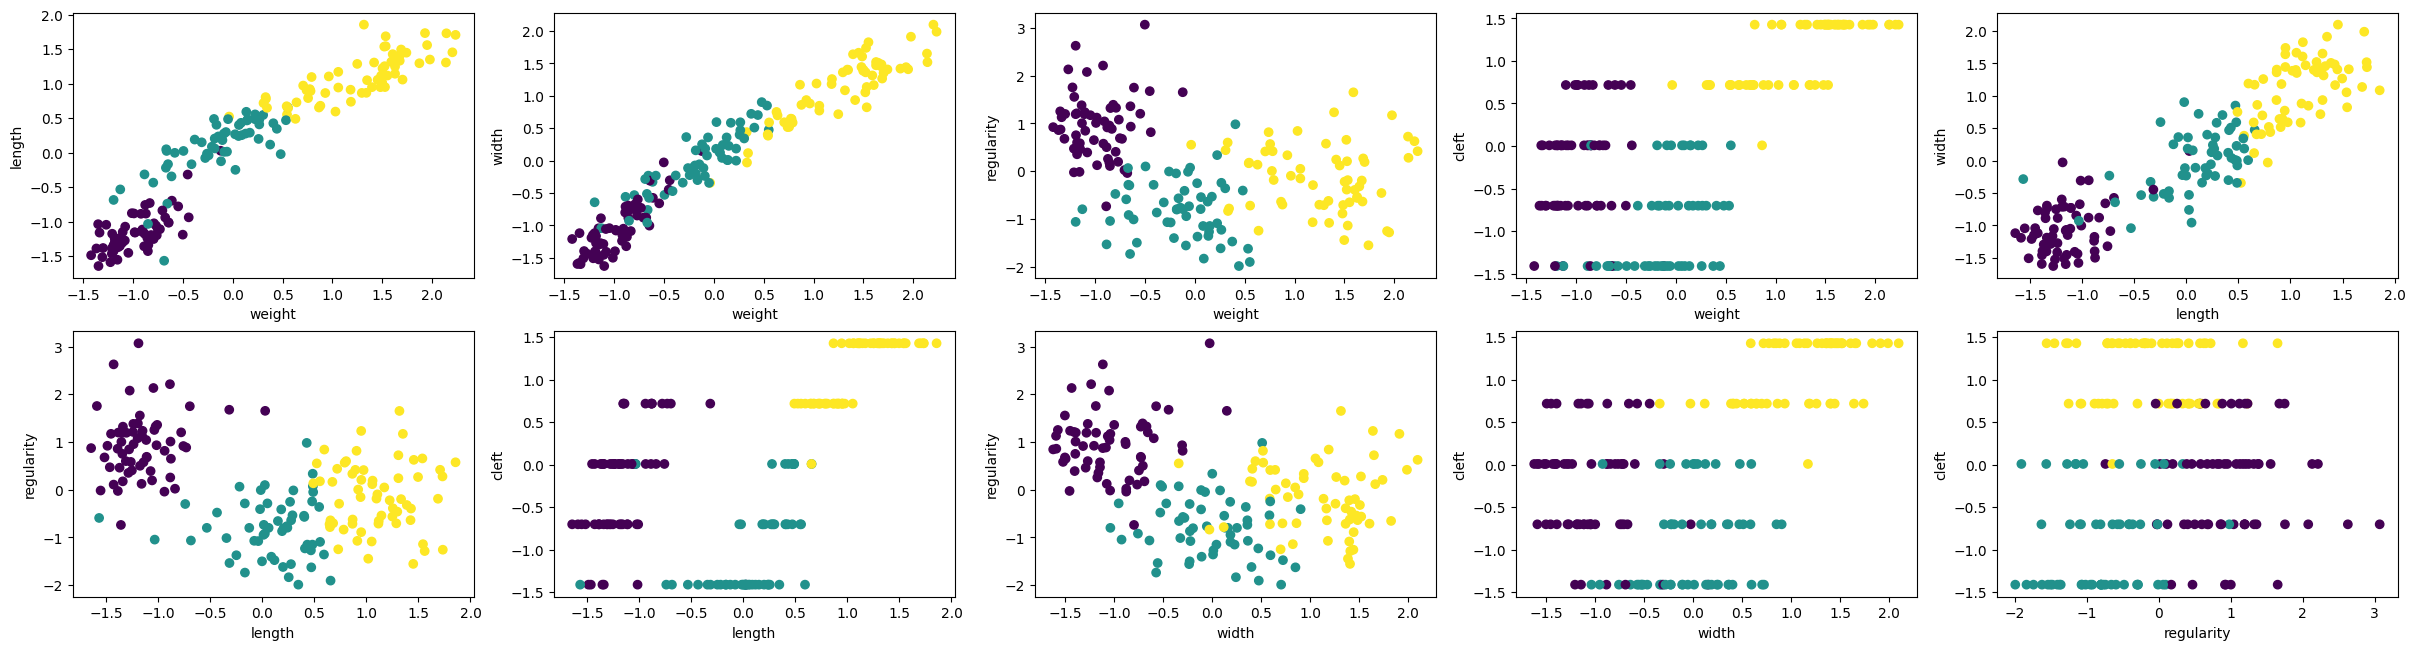

In [37]:
columns = df_imputted.columns
fig = plt.figure(figsize=(30, 20))
for i, (x,y) in enumerate(it.combinations(columns, 2)):
    ax = fig.add_subplot(5, 5, i+1)
    ax.scatter(df_imputted[x], df_imputted[y], c=models_kmeans[2].labels_)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
plt.show()

Las nubes de puntos se separan bastante bien en la mayoría de gráficos, aunque las fronteras son un poco dudosas.

### 4. Conclusión

Vamos a realizar un Análisis de Componentes Principales (PCA) para proyectar nuestro conjunto de datos en un espacio de menor dimensión, preservando la mayor varianza posible.

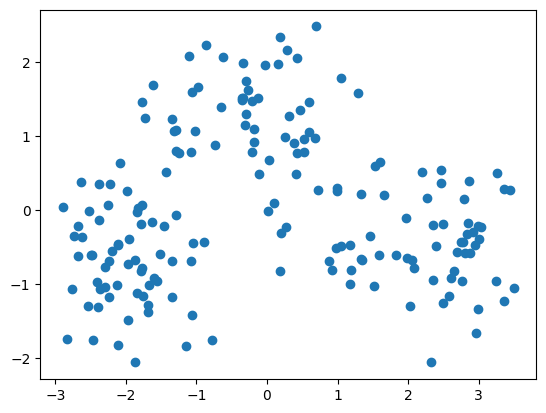

In [38]:
from sklearn.decomposition import PCA
fruits_pca = PCA(n_components=2)
X = fruits_pca.fit_transform(df_imputted)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [39]:
print(fruits_pca.explained_variance_ratio_)
print(fruits_pca.explained_variance_ratio_.sum())

[0.70351134 0.21846242]
0.9219737560234962


Observamos que nuestro modelo PCA explica aproximadamente un 92% de la varianza total, suficiente como para fiarnos de los resultados que aporta. A simple vista parece que se observan 3 clusters, aunque no fácilmente separables. Pintemos los puntos con los resultados de K-Means:

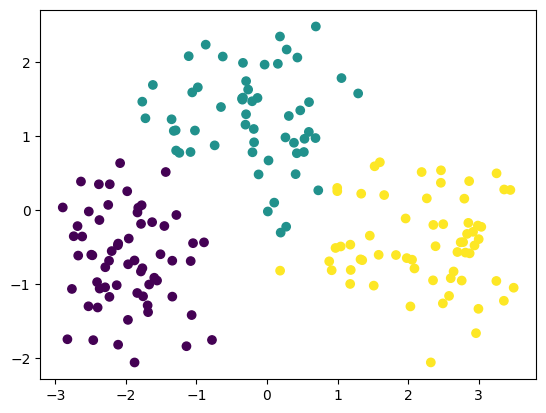

In [40]:
plt.scatter(X[:, 0], X[:, 1], c=models_kmeans[2].labels_)
plt.show()

El modelo que preferimos es K-Means con k=3. Tiene uno de los Silhouette Coefficient más altos, lo cual se confirma al hacer los scatterplots. Además, al aplicar reducción de dimensionalidad con PCA podemos ver que los puntos se separan bastante bien en 3 grupos, a pesar de que las fronteras son dudosas.